In [1]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt
from imutils import contours
from skimage import measure

%matplotlib inline

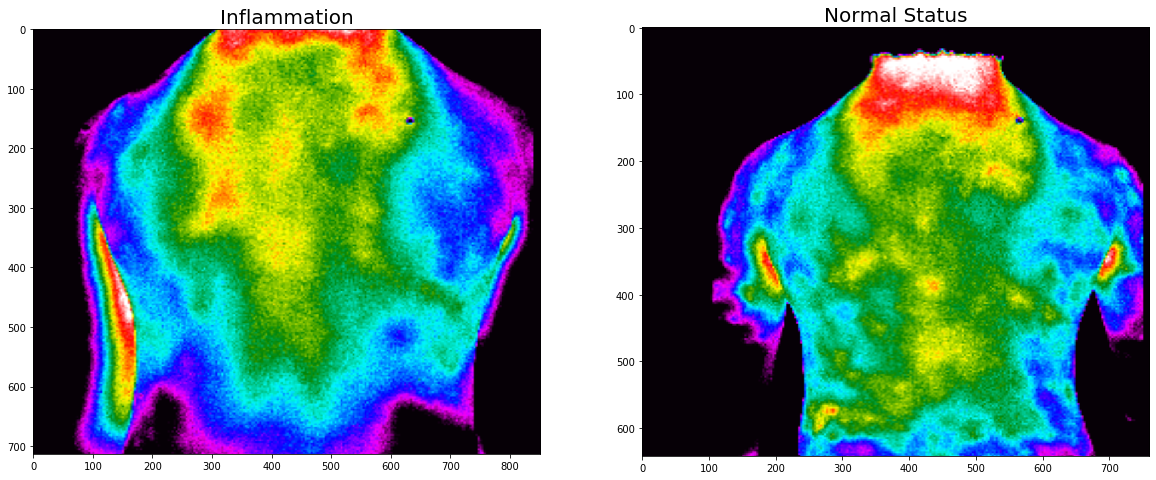

In [2]:
inflam_body = cv2.imread("inflammation.png")
normal_body = cv2.imread("normal.png")

plt.figure(figsize=(20,10))
plt.subplot(121).set_title("Inflammation", size=20), plt.imshow(cv2.cvtColor(inflam_body, cv2.COLOR_BGR2RGB))
plt.subplot(122).set_title("Normal Status", size=20), plt.imshow(cv2.cvtColor(normal_body, cv2.COLOR_BGR2RGB))

plt.show()

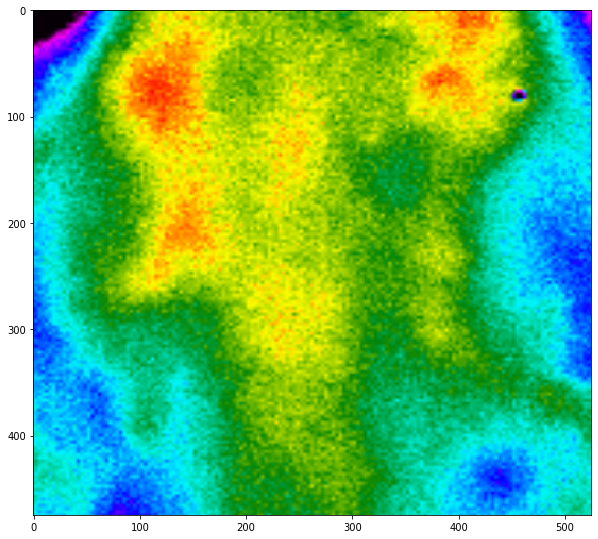

In [3]:
plt.figure(figsize=(10,10))

inflam_lung = inflam_body[75:550, 175:700]

plt.imshow(cv2.cvtColor(inflam_lung, cv2.COLOR_BGR2RGB))
plt.show()

## 通过特定阈值过滤发炎（高温）区域

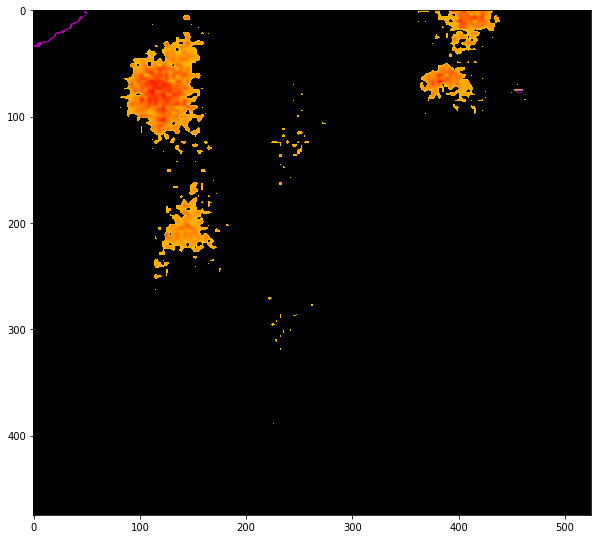

In [4]:
plt.figure(figsize=(10,10))

lower = np.uint8([0, 0, 128])
upper = np.uint8([190, 190, 255])
inflam_mask = cv2.inRange(inflam_lung, lower, upper)
cropped = cv2.bitwise_and(inflam_lung, inflam_lung, mask=inflam_mask)

plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.show()

## 转换为灰度图片并使用高斯模糊降噪和光滑图片

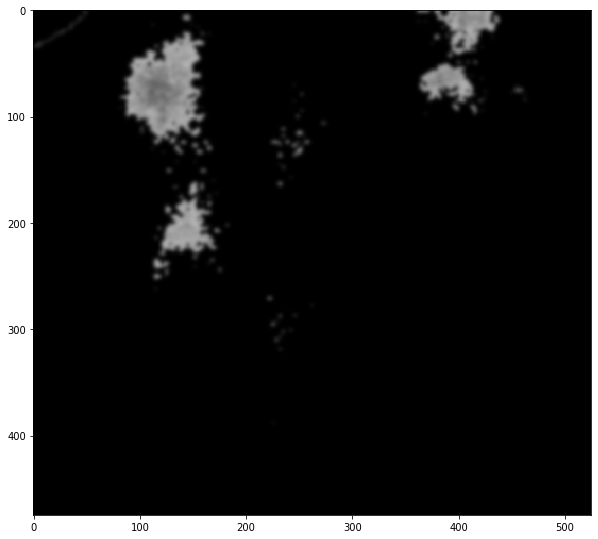

In [5]:
plt.figure(figsize=(10,10))

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

plt.imshow(blurred, cmap='gray', vmin=0, vmax=255)
plt.show()

## 将图片转换以一定阈值转换为黑白图片，并通过腐蚀和膨胀实现降噪和光滑轮廓

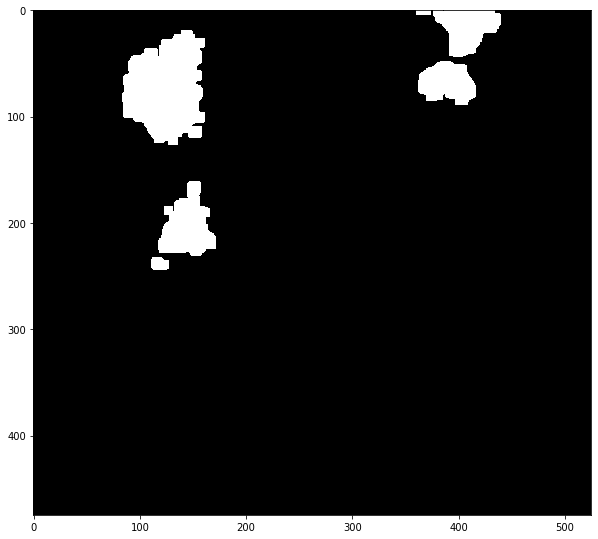

In [6]:
plt.figure(figsize=(10,10))

thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
plt.show()

## 过滤较小区域，避免冗余选区

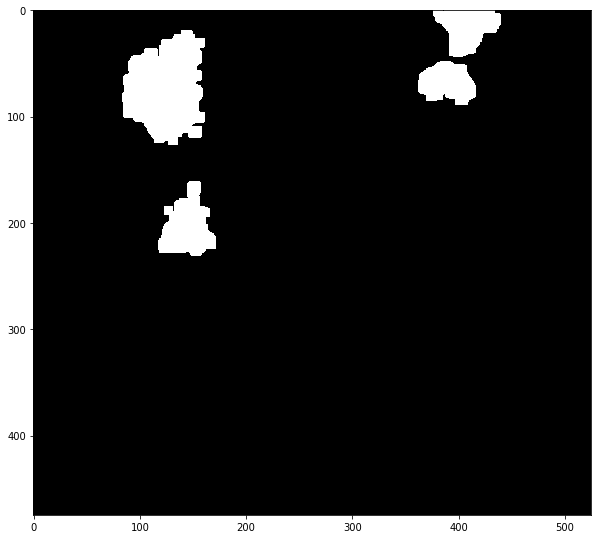

In [7]:
plt.figure(figsize=(10,10))

labels = measure.label(thresh, connectivity=2, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")

for label in np.unique(labels):
    if label == 0:
        continue

    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    if numPixels > 300:
        mask = cv2.add(mask, labelMask)
        
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.show()

## 在原图绘制圆形选区

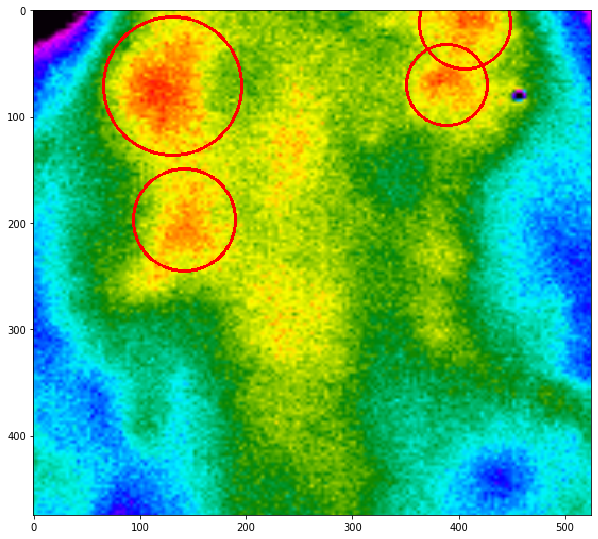

In [8]:
plt.figure(figsize=(10,10))

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    cv2.circle(inflam_lung, (int(cX), int(cY)), int(radius)+10, (0, 0, 255), 2)
    
plt.imshow(cv2.cvtColor(inflam_lung, cv2.COLOR_BGR2RGB))
plt.show()